from hugginface : https://huggingface.co/learn/cookbook/advanced_rag but applied to our corpus

In [1]:
from tqdm import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.documents import Document

from transformers import AutoTokenizer, Pipeline
from sentence_transformers import SentenceTransformer

In [2]:
#EMBEDDING_MODEL_NAME = "thenlper/gte-small"
EMBEDDING_MODEL_NAME = "thenlper/gte-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-base"

## Building the vector database

In [3]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

In [4]:

#loader = TextLoader("corpus/afrique/au-senegal-une-tiktokeuse-qui-vendait-des-boulettes-pour-faire-grossir-les-fesses-poursuivie.txt")
text_loader_kwargs = {"autodetect_encoding": True}
loader = DirectoryLoader("corpus/", glob='**/**/*.txt', loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
docs = loader.load()

In [5]:
docs_processed = []
for doc in docs:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


100%|██████████| 176/176 [00:00<00:00, 1867.18it/s]


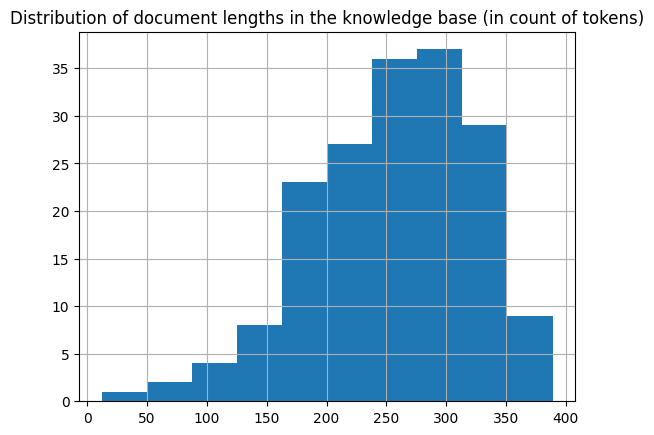

In [6]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
model_max_length = SentenceTransformer('thenlper/gte-small').max_seq_length
print(f"Model's maximum sequence length: {model_max_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### Split documents

In [7]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[Document],
    tokenizer,
) -> List[Document]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    model_max_length,
    docs,
    tokenizer,
)

100%|██████████| 119/119 [00:00<00:00, 1397.71it/s]


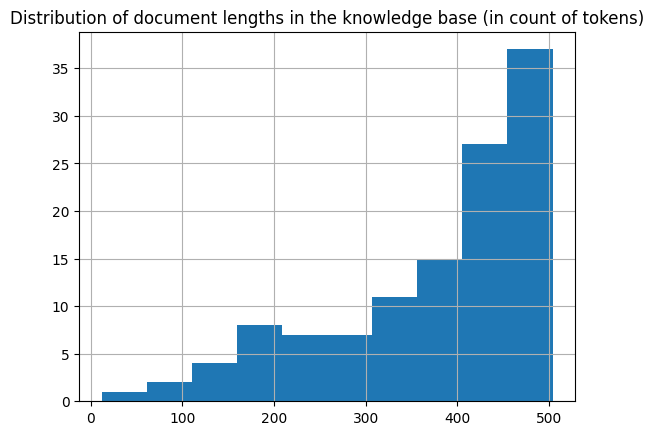

In [8]:
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### Vector Database

In [9]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

vector_database = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_30536\3932242158.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


# DeepSeek

In [10]:
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

In [11]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [12]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [13]:
llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=1500,
)

Device set to use cuda:0


### Prompt

In [14]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """
You are a news reporter summerizing news for the last 24 hours. 
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from the selected documents. 
Just give facts, don't draw any conclusions.

Context:
{context}

""",
    },
    {
        "role": "user",
        "content": """
---
Now, here are the subjects from which you should build your news reports.

subject: What are the most important news reguarding {subject} ? """,
    },
]

rag_prompt_template = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(rag_prompt_template)

<｜begin▁of▁sentence｜>
You are a news reporter summerizing news for the last 24 hours. 
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from the selected documents. 
Just give facts, don't draw any conclusions.

Context:
{context}

<｜User｜>
---
Now, here are the subjects from which you should build your news reports.

subject: What are the most important news reguarding {subject} ? <｜Assistant｜><think>



### Reranking model (not used)

In [15]:
from ragatouille import RAGPretrainedModel

reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

f:\Projects\Repos\RT_News_Summarizer\.venv\Lib\site-packages\colbert\utils\amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


### All together

In [ ]:
def answer_with_rag(
            subject: str,
            llm: Pipeline,
            knowledge_index: FAISS,
            reranker: Optional[RAGPretrainedModel] = None,
            num_retrieved_docs: int = 30,
            num_docs_final: int = 5,
        ) -> Tuple[str, List[Document]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=subject, k=num_retrieved_docs)

    relevant_docs_text = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs_text = reranker.rerank(subject, relevant_docs_text, k=num_docs_final)
        relevant_docs_text = [doc["content"] for doc in relevant_docs_text]

    relevant_docs_text = relevant_docs_text[:num_docs_final]
    relevant_docs = relevant_docs[:num_docs_final]

    #relevant_docs_text = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs_text)])

    final_prompt = rag_prompt_template.format(subject=subject, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs_text, relevant_docs

### Test query

In [ ]:
subject = "Trump"

answer, relevant_docs_text, relevant_docs = answer_with_rag(subject, llm, vector_database, reranker=None, num_retrieved_docs=30, num_docs_final=7)
#answer, relevant_docs_text, relevant_docs = answer_with_rag(subject, llm, vector_database, reranker=reranker, num_retrieved_docs=30, num_docs_final=7)

=> Retrieving documents...
=> Generating answer...


f:\Projects\Repos\RT_News_Summarizer\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
f:\Projects\Repos\RT_News_Summarizer\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


### Removing `<think>...<\think>` tokens from deepseek

In [18]:
import re

answer_no_think = re.sub(r".*?</think>", "", answer, flags=re.DOTALL)
answer_no_think = answer_no_think.lstrip()
print(answer_no_think)

Here is a structured summary of the key points regarding Donald Trump based on the provided context:

---

### **Key Points on Donald Trump**

#### **1. Trump's Direct Statements**
   - Trump has repeatedly called for dialogue with Palestinian groups, emphasizing their rights and needs.
   - He has emphasized the importance of human rights and the need for a more just international order.

#### **2. Trump's Calls for Action**
   - Trump has suggested that PA groups should be allowed to live independently in non-Palestine territories, such as Gaza.
   - He has also proposed measures to address political tensions between the U.S. and other countries, particularly those targeting PA groups.

#### **3. Trump's Administration Response**
   - Trump's administration has been actively responding to the challenges posed by PA groups, including calls for dialogue and support for human rights causes.
   - They have introduced initiatives to promote peace and development in PA regions.

#### **4. 

### Showing source html links

In [19]:
import json

def show_source_link_from_relevant_docs(relevant_docs):
    metas = [doc.metadata for doc in relevant_docs]
    sources = [(meta['source']) for meta in metas]
    sources = list(set(sources))

    for source_link in sources:
        meta_link = source_link.replace(".txt", ".meta")
        with open(meta_link, "r") as file:
            loaded_data = json.load(file)
        print(loaded_data['title'])
        print(loaded_data['link'])
        print('')

show_source_link_from_relevant_docs(relevant_docs)

En Afrique du Sud, le malaise des nationalistes afrikaners invités à l’exil par Donald Trump
https://www.lemonde.fr/afrique/article/2025/02/10/en-afrique-du-sud-le-malaise-des-nationalistes-afrikaners-invites-a-l-exil-par-donald-trump_6540648_3212.html

L’extrême droite européenne à l’ombre de Trump
https://www.lemonde.fr/idees/article/2025/02/10/l-extreme-droite-europeenne-a-l-ombre-de-trump_6540097_3232.html

Gaza : Donald Trump déclare que les Palestiniens n’auraient pas de droit au retour dans le cadre de son plan pour le territoire
https://www.lemonde.fr/international/article/2025/02/10/gaza-donald-trump-declare-que-les-palestiniens-n-auraient-pas-de-droit-au-retour-dans-le-cadre-de-son-plan-pour-le-territoire_6540443_3210.html

